In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import dill
import gym


# To avoid Type3 fonts in generated pdf file
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# EXPERIMENT CONFIGURATION

In [2]:
CART_POLE = "CartPole-v0" 
METRICS_FREQUENCY = 1

# The number of samples to be replayed druing ER phase
ER_SAMPLES_NUMBER_LIST = [1,2,3,5,8,13]

EXPERIMENT_NAME = "5"
DATA_BASE_PATH = "" # CURRENT LOCATION
DATA_PATH = os.path.join(DATA_BASE_PATH, 'CP', EXPERIMENT_NAME, CART_POLE)


In [3]:
import math

env = gym.make(CART_POLE)

_high = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]
_low = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]

# working (1, 1, 10, 14)
buckets = (1, 1, 6, 6)

class CartPoleObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)

    def observation(self, obs):
        ratios = [(obs[i] + abs(_low[i])) / (_high[i] - _low[i]) for i in range(len(obs))]
        new_obs = [int(round((buckets[i] - 1) * ratios[i])) for i in range(len(obs))]
        new_obs = [min(buckets[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
        return [str(o) for o in new_obs]

E:\_ZSSE\Anaconda\envs\pyalcs-experiments-acs2er\lib\site-packages\gym\envs\registration.py:506: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  f"The environment {path} is out of date. You should consider "


## DATA

In [4]:
def _load_data(path, file_name):
    full_dir_path = os.path.join(DATA_PATH, path)
    data_list = []
    for d in os.listdir(full_dir_path):
        full_file_path = os.path.join(full_dir_path, d, f'{file_name}.dill')
        data_list.append(dill.load(open(full_file_path, 'rb')))

    return data_list

def _load_agent_data(agent_name, path, file_name):
    path = os.path.join(agent_name, path)
    return _load_data(path, file_name)

def _load_metrics(agent_name, path, metrics_name):
    return _load_agent_data(agent_name, path, f'metrics_{metrics_name}')

def _load_explore_metrics(agent_name, path):
    return _load_metrics(agent_name, path, 'EXPLORE')

def _load_exploit_metrics(agent_name, path):
    return _load_metrics(agent_name, path, 'EXPLOIT')

def _load_population(agent_name, path):
    return _load_agent_data(agent_name, path, 'population')

def _load_environment(agent, path):
    return _load_agent_data(agent, path, 'env')
    
def _load_experiment_data(agent_name, path):
    explore_metrics = _load_explore_metrics(agent_name, path)
    exploit_metrics = _load_exploit_metrics(agent_name, path)
    population = _load_population(agent_name, path)
    env = _load_environment(agent_name, path)

    return (explore_metrics, exploit_metrics, population, env)

def load_acs2_experiment_data():
    return _load_experiment_data('ACS2', '')

def _load_acs2er_experiment_data(er_samples_number):
    return _load_experiment_data('ACS2ER', f'm_{er_samples_number}')

def load_acs2er_experiments_data():
    return list(map(lambda m: (m, _load_acs2er_experiment_data(m)), ER_SAMPLES_NUMBER_LIST))

## Data Analysis

In [5]:
def parse_metrics_to_df(explore_metrics, exploit_metrics):
    def extract_details(row):
        row['trial'] = row['trial']
        row['numerosity'] = row['numerosity']
        row['reliable'] = row['reliable']
        row['steps_in_trial'] = row['steps_in_trial']
        row['reward'] = row['reward']
        return row
    
    explore_metrics_list = []
    exploit_metrics_list = []
    for i in range(len(explore_metrics)):
        explore_df = pd.DataFrame(explore_metrics[i])
        exploit_df = pd.DataFrame(exploit_metrics[i])
        explore_df = explore_df.apply(extract_details, axis=1)
        exploit_df = exploit_df.apply(extract_details, axis=1)

        explore_metrics_list.append(explore_df)
        exploit_metrics_list.append(exploit_df)

    explore_df = pd.concat(explore_metrics_list)
    explore_df = explore_df.groupby(explore_df.index).mean()

    exploit_df = pd.concat(exploit_metrics_list)
    exploit_df = exploit_df.groupby(exploit_df.index).mean()
    
    # Mark them with specific phase
    explore_df['phase'] = 'explore'
    exploit_df['phase'] = 'exploit'
    
    # Adjuts exploit trial counter
    exploit_df['trial'] = exploit_df.apply(lambda r: r['trial']+len(explore_df), axis=1)
    
    # Concatenate both dataframes
    df = pd.concat([explore_df, exploit_df])
    df.set_index('trial', inplace=True)
    
    return df


# Plot constants
TITLE_TEXT_SIZE=24
AXIS_TEXT_SIZE=18
LEGEND_TEXT_SIZE=16


In [6]:
def get_acs2_experiment_data():
  explore_metrics, exploit_metrics, population, env = load_acs2_experiment_data()
  metrics_average = parse_metrics_to_df(explore_metrics, exploit_metrics)

  return (metrics_average, population[0], env[0])

def get_acs2er_experiments_data():
  data = []
  for m, (explore_metrics, exploit_metrics, population, env) in load_acs2er_experiments_data():
    metrics_average = parse_metrics_to_df(explore_metrics, exploit_metrics)

    data.append((m, (metrics_average, population[0], env[0])))

  return data

acs2_data = get_acs2_experiment_data()
acs2er_data = get_acs2er_experiments_data()

E:\_ZSSE\Anaconda\envs\pyalcs-experiments-acs2er\lib\site-packages\mlflow\protos\scalapb\scalapb_pb2.py:25: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  dependencies=[google_dot_protobuf_dot_descriptor__pb2.DESCRIPTOR,])
E:\_ZSSE\Anaconda\envs\pyalcs-experiments-acs2er\lib\site-packages\mlflow\protos\scalapb\scalapb_pb2.py:35: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  serialized_options=None, file=DESCRIPTOR)
E:\_ZSSE\Anaconda\envs\pyalcs-experiments-acs2er\lib\site-packages\mlflow\protos\scalapb\scalapb_pb2.py:95: DeprecationWarning: Call to deprecated create function Descriptor(). Note: Create unlinked descriptors is going to go away. Please use get/fi

In [11]:
# KNOWLEDGE_ATTRIBUTE = 'knowledge'
NUMEROSITY_ATTRIBUTE = 'numerosity'
RELIABLE_ATTRIBUTE = 'reliable'
STEPS_IN_TRIAL_ATTRIBUTE = 'steps_in_trial'

plt.rcParams['figure.figsize'] = [13, 10]

def get_explore_metrics(metrics):
    return metrics.query("phase == 'explore'")

def get_exploit_metrics(metrics):
    return metrics.query("phase == 'exploit'")

def plot_attribute(metrics, attribute_name: str, label: str, explore_color: str, exploit_color: str, width: float = 1.5):
    explore = get_explore_metrics(metrics)
    exploit = get_exploit_metrics(metrics)

    x_axis_explore = range(1, len(explore) + 1)
    x_axis_exploit = range(len(explore) + 1, len(explore) + len(exploit) + 1)

    plt.plot(x_axis_explore, explore[attribute_name], c=explore_color, label=label, linewidth=width)
    plt.plot(x_axis_exploit, exploit[attribute_name], c=exploit_color, linewidth=width)

def plot_attribute_moving_average(metrics, attribute_name: str, explore_moving_avg_win: int, exploit_moving_avg_win: int, label: str, explore_color: str, exploit_color: str, width: float = 1.5):
    explore = get_explore_metrics(metrics)
    exploit = get_exploit_metrics(metrics)

    x_axis_explore = range(1, len(explore) + 1)
    x_axis_exploit = range(len(explore) + 1, len(explore) + len(exploit) + 1)

    plt.plot(x_axis_explore, explore[attribute_name].rolling(explore_moving_avg_win, min_periods=1, closed='both').mean(), c=explore_color, label=label, linewidth=width)
    plt.plot(x_axis_exploit, exploit[attribute_name].rolling(exploit_moving_avg_win, min_periods=1, closed='both').mean(), c=exploit_color, linewidth=width)

# def plot_multiple_knowledge(metrics_list, title, width: float = 1.5):
#     plt.close()
#     plt.title(f"KNOWLEDGE - {title}")

#     for (label, explore_color, exploit_color), metric in metrics_list:
#         plot_attribute(metric, KNOWLEDGE_ATTRIBUTE, label, explore_color, exploit_color, width)

#     plt.axvline(x=len(get_explore_metrics(metrics_list[0][1])), c='black', linestyle='dashed')

#     plt.legend()
#     plt.xlabel(f"Trial x {METRICS_FREQUENCY}")
#     plt.ylabel("Knowledge")
#     plt.show()

def plot_multiple_classifiers(metrics_list, title, width: float = 1.5):
    plt.close()
    plt.title(f"CLASSIFIERS NUMEROSITY (num) and RELIABLE (rel) - {title}")
    
    for (label, num_color, rel_color), metric in metrics_list:
        plot_attribute(metric, NUMEROSITY_ATTRIBUTE, f'{label}-num', num_color, num_color, width)
        plot_attribute(metric, RELIABLE_ATTRIBUTE, f'{label}-rel', rel_color, rel_color, width)

    plt.axvline(x=len(get_explore_metrics(metrics_list[0][1])), c='black', linestyle='dashed')

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel(f"Trial")
    plt.ylabel("Classifiers")
    plt.show()

def plot_multiple_steps_in_trial(metrics_list, title, width: float = 1.5, explore_moving_avg_win: int = 100, exploit_moving_avg_win: int = 100):
    plt.close()
    plt.title(f"STEPS - {title}")

    for (label, explore_color, exploit_color), metric in metrics_list:
        # metric = metric.rolling(moving_average_window, on = REWARD_ATTRIBUTE).mean()
        plot_attribute_moving_average(metric, STEPS_IN_TRIAL_ATTRIBUTE, explore_moving_avg_win, exploit_moving_avg_win, label, explore_color, exploit_color, width)

    plt.axvline(x=len(get_explore_metrics(metrics_list[0][1])), c='black', linestyle='dashed')

    plt.legend()
    plt.xlabel(f"Trial x {METRICS_FREQUENCY}")
    plt.ylabel("STEPS")
    plt.show()

def print_average_exploit_steps_in_trial(metrics, label: str):
    exploit = get_exploit_metrics(metrics)

    reward_avg = np.mean(np.array(exploit[STEPS_IN_TRIAL_ATTRIBUTE]))

    print(f"STEPS {label}: {reward_avg}")

# def print_knowledge_completed(metrics, label: str):
#     explore = get_explore_metrics(metrics)
#     knowledge_completed = explore.query(f"{KNOWLEDGE_ATTRIBUTE} == 100")

#     if(len(knowledge_completed) == 0):
#         print(f"Knowledge for {label} NOT completed")

#         return

#     print(f"Knowledge for {label} completed at trial: {knowledge_completed.index[0]}")

# def print_knowledge_above_threshold(metrics, threshold, label: str):
#     explore = get_explore_metrics(metrics)
#     knowledge_completed = explore.query(f"{KNOWLEDGE_ATTRIBUTE} > {threshold}")

#     if(len(knowledge_completed) == 0):
#         print(f"Knowledge for {label} NOT over threshold: {threshold} %")

#         return

#     print(f"Knowledge for {label} over threshold: {threshold} % at trial: {knowledge_completed.index[0]}")

def print_all_classifiers_reliable(metrics, label: str):
    explore = get_explore_metrics(metrics)
    numerosity_reliable = explore.query(f"{NUMEROSITY_ATTRIBUTE} > {0}")
    numerosity_reliable = numerosity_reliable.query(f"{NUMEROSITY_ATTRIBUTE} == {RELIABLE_ATTRIBUTE}")

    if(len(numerosity_reliable) == 0):
        num = explore[NUMEROSITY_ATTRIBUTE].values[-1]
        rel = explore[RELIABLE_ATTRIBUTE].values[-1]
        print(f"{label}: NOT All Classifiers reliable. NUM: {num}, REL: {rel}, GAP: {num - rel}")

        return


    print(f"{label}: All Classifiers reliable at trial: {numerosity_reliable.index[0]}. NUM: {numerosity_reliable[NUMEROSITY_ATTRIBUTE].values[-1]}")


In [12]:
# def plot_acs2er_knowledge():
#     # COLORS = ['r', 'g', 'b']
#     COLORS = ['#FF9634', '#FFEE15', '#A7FF15', '#29FF2F', '#44FBD1', '#49BDFA', '#316EF9', '#965FFF', '#FE4DFE', '#FF63A5']

#     def get_metric_record(index, data):
#         m, (metric, _, _) = data

#         return (f'm-{m}', COLORS[index], COLORS[index]), metric

#     metrics_list = list(map(lambda d: get_metric_record(d[0], d[1]), enumerate(acs2er_data)))

#     plot_multiple_knowledge(metrics_list, 'ACS2ER')

def plot_acs2er_classifiers():
    # COLORS_NUM = ['r', 'g', 'b']
    COLORS_NUM = ['#FF9634', '#FFEE15', '#A7FF15', '#29FF2F', '#44FBD1', '#49BDFA', '#316EF9', '#965FFF', '#FE4DFE', '#FF63A5']

    # COLORS_REL = ['#FFA4A4', '#A4FFB3', '#A4FEFF']
    COLORS_REL = ['#FFCD9F', '#FFF89F', '#D6FF91', '#BEFFBF', '#C2FFF1', '#C0EAFF', '#C2D5FF', '#DAC7FF', '#FDAAFD', '#F6C5DA']

    def get_metric_record(index, data):
        m, (metric, _, _) = data

        return (f'm-{m}', COLORS_NUM[index], COLORS_REL[index]), metric

    metrics_list = list(map(lambda d: get_metric_record(d[0], d[1]), enumerate(acs2er_data)))

    plot_multiple_classifiers(metrics_list, 'ACS2ER')

def plot_acs2er_steps_in_trial():
    # COLORS = ['r', 'g', 'b']
    COLORS = ['#FF9634', '#FFEE15', '#A7FF15', '#29FF2F', '#44FBD1', '#49BDFA', '#316EF9', '#965FFF', '#FE4DFE', '#FF63A5']

    def get_metric_record(index, data):
        m, (metric, _, _) = data

        return (f'm-{m}', COLORS[index], COLORS[index]), metric

    metrics_list = list(map(lambda d: get_metric_record(d[0], d[1]), enumerate(acs2er_data)))

    plot_multiple_steps_in_trial(metrics_list, 'ACS2ER')

def print_acs2er_exploit_steps_in_trial():
    for m, (metric, _, _) in acs2er_data:
        print_average_exploit_steps_in_trial(metric, f'M-{m}')

# def print_acs2er_knowledge_completed():
#     for m, (metric, _, _) in acs2er_data:
#         print_knowledge_completed(metric, f'M-{m}')

# def print_acs2er_knowledge_above_threshold(threshold):
#     for m, (metric, _, _) in acs2er_data:
#         print_knowledge_above_threshold(metric, threshold, f'M-{m}')

def print_acs2er_all_classifiers_reliable():
    for m, (metric, _, _) in acs2er_data:
        print_all_classifiers_reliable(metric, f'M-{m}')

# def plot_acs2_acs2er_knowledge():
#     # COLORS = ['r', 'g', 'b']
#     COLORS = ['#FF9634', '#FFEE15', '#A7FF15', '#29FF2F', '#44FBD1', '#49BDFA', '#316EF9', '#965FFF', '#FE4DFE', '#FF63A5']
#     acs2_metric, _, _ = acs2_data
#     def get_metric_record(index, data):
#         m, (metric, _, _) = data

#         return (f'acs2er - m-{m}', COLORS[index], COLORS[index]), metric

#     metrics_list = list(map(lambda d: get_metric_record(d[0], d[1]), enumerate(acs2er_data)))
#     metrics_list.append((('acs2', '#FF2E2E', '#FF2E2E'), acs2_metric))

#     plot_multiple_knowledge(metrics_list, 'ACS2ER vs ACS2')

def plot_acs2_acs2er_classifiers():
    # COLORS_NUM = ['r', 'g', 'b']
    COLORS_NUM = ['#FF9634', '#FFEE15', '#A7FF15', '#29FF2F', '#44FBD1', '#49BDFA', '#316EF9', '#965FFF', '#FE4DFE', '#FF63A5']

    # COLORS_REL = ['#FFA4A4', '#A4FFB3', '#A4FEFF']
    COLORS_REL = ['#FFCD9F', '#FFF89F', '#D6FF91', '#BEFFBF', '#C2FFF1', '#C0EAFF', '#C2D5FF', '#DAC7FF', '#FDAAFD', '#F6C5DA']

    acs2_metric, _, _ = acs2_data
    def get_metric_record(index, data):
        m, (metric, _, _) = data

        return (f'acs2er-{m}', COLORS_NUM[index], COLORS_REL[index]), metric

    metrics_list = list(map(lambda d: get_metric_record(d[0], d[1]), enumerate(acs2er_data)))
    metrics_list.append((('acs2', '#FF2E2E', '#FF9898'), acs2_metric))

    plot_multiple_classifiers(metrics_list, 'ACS2ER vs ACS2')

def plot_acs2_acs2er_steps_in_trial():
    # COLORS = ['r', 'g', 'b']
    COLORS = ['#FF9634', '#FFEE15', '#A7FF15', '#29FF2F', '#44FBD1', '#49BDFA', '#316EF9', '#965FFF', '#FE4DFE', '#FF63A5']
    acs2_metric, _, _ = acs2_data
    def get_metric_record(index, data):
        m, (metric, _, _) = data

        return (f'acs2er - m-{m}', COLORS[index], COLORS[index]), metric

    metrics_list = list(map(lambda d: get_metric_record(d[0], d[1]), enumerate(acs2er_data)))
    metrics_list.append((('acs2', '#FF2E2E', '#FF2E2E'), acs2_metric))

    plot_multiple_steps_in_trial(metrics_list, 'ACS2ER vs ACS2')

def print_acs2_acs2er_exploit_steps_in_trial():
    acs2_metric, _, _ = acs2_data
    print_average_exploit_steps_in_trial(acs2_metric, f'ACS2')
    for m, (metric, _, _) in acs2er_data:
        print_average_exploit_steps_in_trial(metric, f'ACS2ER - M-{m}')

# def print_acs2_acs2er_knowledge_completed():
#     acs2_metric, _, _ = acs2_data
#     print_knowledge_completed(acs2_metric, f'ACS2')
#     for m, (metric, _, _) in acs2er_data:
#         print_knowledge_completed(metric, f'ACS2ER - M-{m}')
    
# def print_acs2_acs2er_knowledge_above_threshold(threshold):
#     acs2_metric, _, _ = acs2_data
#     print_knowledge_above_threshold(acs2_metric, threshold, f'ACS2')
#     for m, (metric, _, _) in acs2er_data:
#         print_knowledge_above_threshold(metric, threshold, f'ACS2ER - M-{m}')

def print_acs2_acs2er_all_classifiers_reliable():
    acs2_metric, _, _ = acs2_data
    print_all_classifiers_reliable(acs2_metric, f'ACS2')
    for m, (metric, _, _) in acs2er_data:
        print_all_classifiers_reliable(metric, f'ACS2ER - M-{m}')

# ACS2ER Results

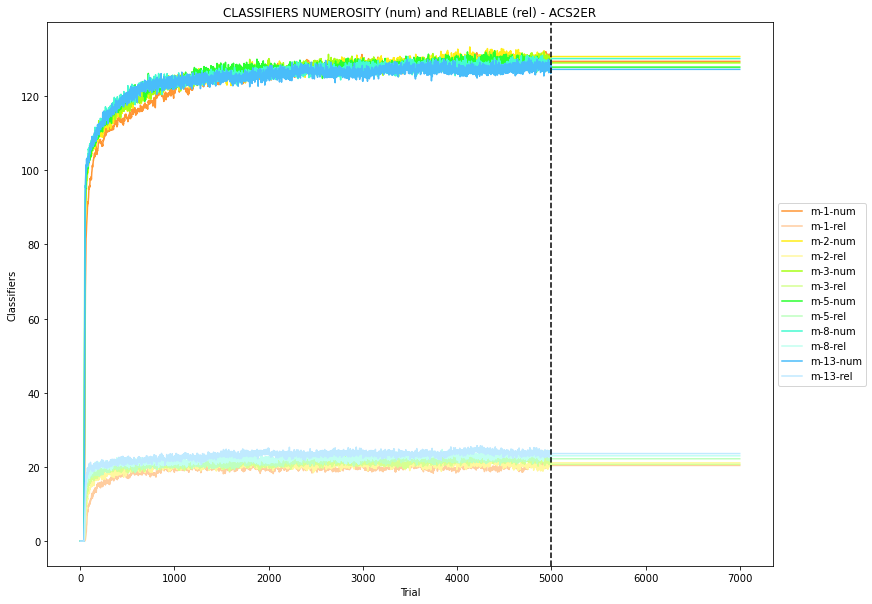

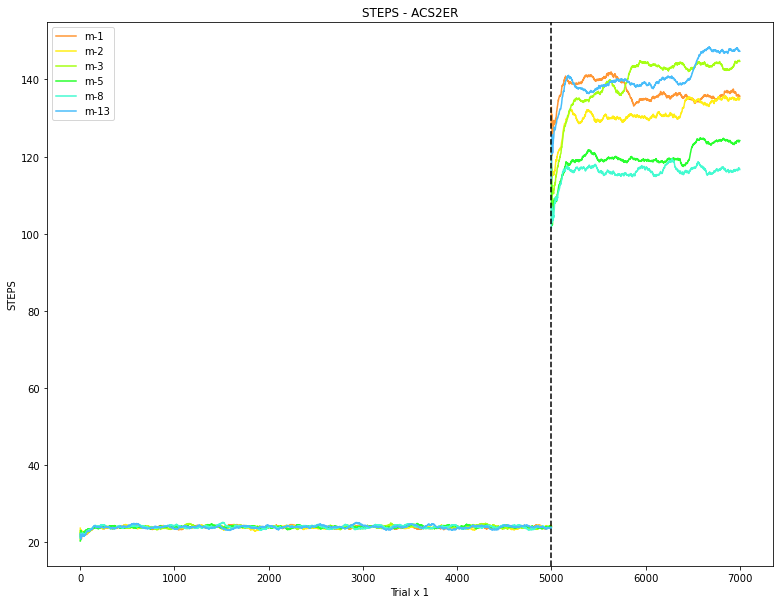

STEPS M-1: 136.974175
STEPS M-2: 131.376625
STEPS M-3: 139.92665
STEPS M-5: 120.25882500000002
STEPS M-8: 116.27555000000001
STEPS M-13: 140.88882500000003
M-1: NOT All Classifiers reliable. NUM: 129.35, REL: 20.4, GAP: 108.94999999999999
M-2: NOT All Classifiers reliable. NUM: 130.65, REL: 21.1, GAP: 109.55000000000001
M-3: NOT All Classifiers reliable. NUM: 128.95, REL: 20.7, GAP: 108.24999999999999
M-5: NOT All Classifiers reliable. NUM: 127.8, REL: 22.2, GAP: 105.6
M-8: NOT All Classifiers reliable. NUM: 130.1, REL: 23.0, GAP: 107.1
M-13: NOT All Classifiers reliable. NUM: 127.2, REL: 23.6, GAP: 103.6


In [13]:
# plot_acs2er_knowledge()
plot_acs2er_classifiers()
plot_acs2er_steps_in_trial()
print_acs2er_exploit_steps_in_trial()
# print_acs2er_knowledge_completed()
# print_acs2er_knowledge_above_threshold(95)
print_acs2er_all_classifiers_reliable()

## ACS2 vs ACS2ER

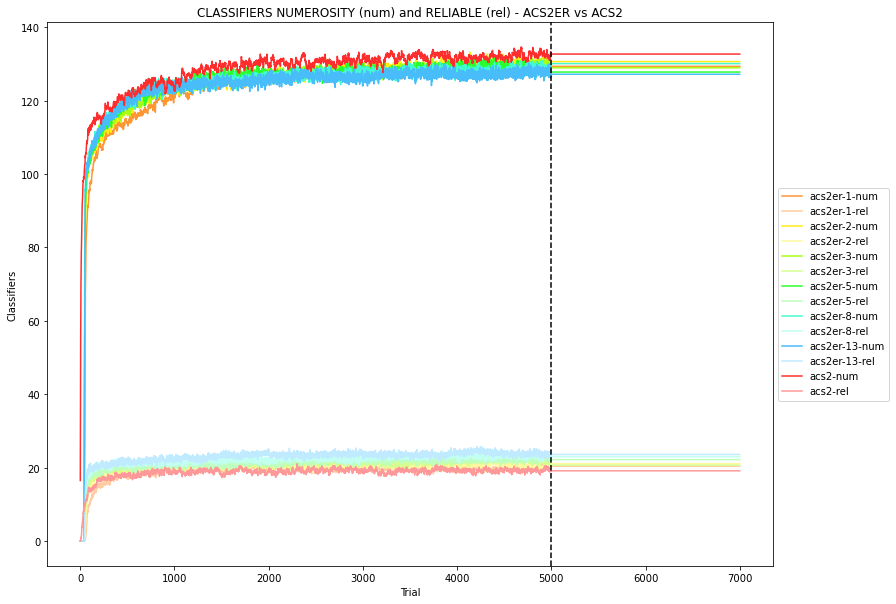

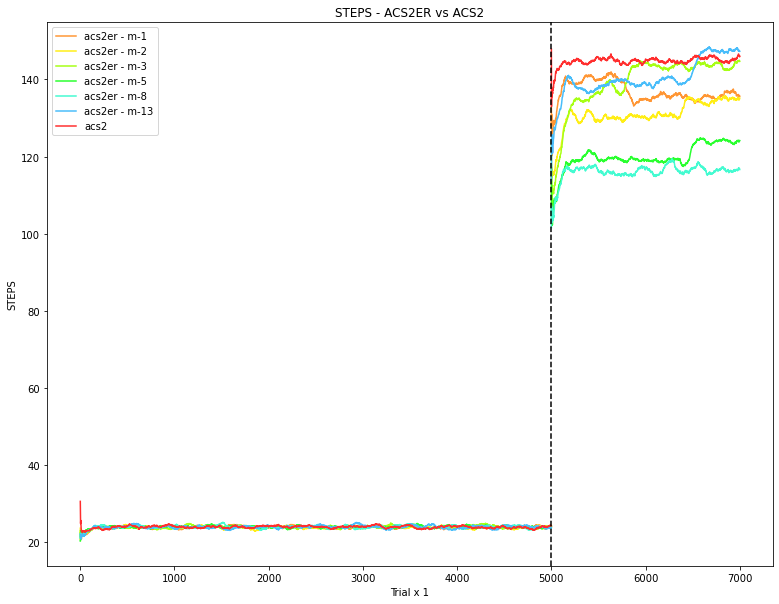

STEPS ACS2: 144.867025
STEPS ACS2ER - M-1: 136.974175
STEPS ACS2ER - M-2: 131.376625
STEPS ACS2ER - M-3: 139.92665
STEPS ACS2ER - M-5: 120.25882500000002
STEPS ACS2ER - M-8: 116.27555000000001
STEPS ACS2ER - M-13: 140.88882500000003
ACS2: NOT All Classifiers reliable. NUM: 132.7, REL: 19.15, GAP: 113.54999999999998
ACS2ER - M-1: NOT All Classifiers reliable. NUM: 129.35, REL: 20.4, GAP: 108.94999999999999
ACS2ER - M-2: NOT All Classifiers reliable. NUM: 130.65, REL: 21.1, GAP: 109.55000000000001
ACS2ER - M-3: NOT All Classifiers reliable. NUM: 128.95, REL: 20.7, GAP: 108.24999999999999
ACS2ER - M-5: NOT All Classifiers reliable. NUM: 127.8, REL: 22.2, GAP: 105.6
ACS2ER - M-8: NOT All Classifiers reliable. NUM: 130.1, REL: 23.0, GAP: 107.1
ACS2ER - M-13: NOT All Classifiers reliable. NUM: 127.2, REL: 23.6, GAP: 103.6


In [14]:
# plot_acs2_acs2er_knowledge()
plot_acs2_acs2er_classifiers()
plot_acs2_acs2er_steps_in_trial()
print_acs2_acs2er_exploit_steps_in_trial()
# print_acs2_acs2er_knowledge_completed()
# print_acs2_acs2er_knowledge_above_threshold(95)
print_acs2_acs2er_all_classifiers_reliable()